In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [9]:
import pandas as pd
import yfinance as yf

# Get Microsoft earnings
msft = yf.Ticker("MSFT")
earnings = msft.quarterly_financials.T[['Net Income']]
earnings.index = pd.to_datetime(earnings.index)
earnings = earnings.sort_index()

# Spread quarterly earnings over months (approximate)
monthly_earnings = earnings.resample('ME').ffill()
monthly_earnings.columns = ['Earnings']
monthly_earnings = monthly_earnings['2021-03-01':'2024-03-01']
monthly_earnings.tail()

,Earnings
2023-12-31,21870000000.0
2024-01-31,21870000000.0
2024-02-29,21870000000.0


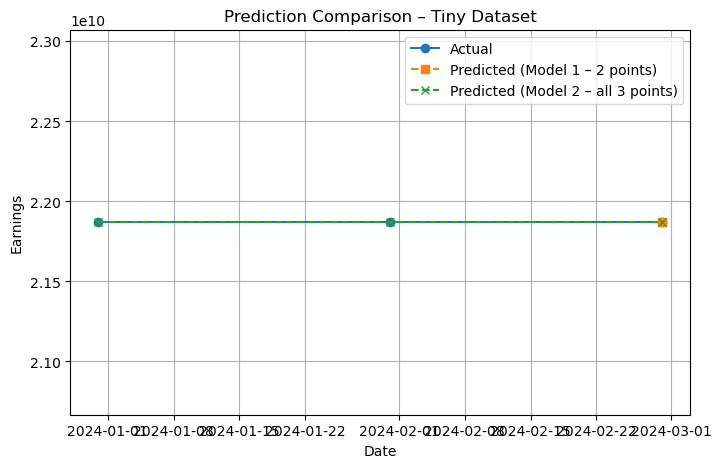

In [10]:
# Load Inflation Data
import pandas_datareader.data as pdr

inflation = pdr.DataReader('CPIAUCSL', 'fred', start='2021-03-01', end='2024-03-01')
inflation = inflation.resample('ME').mean().rename(columns={'CPIAUCSL': 'Inflation'})

# Merge and model
merged = pd.merge(inflation, monthly_earnings, left_index=True, right_index=True).dropna()

X = merged[['Inflation']]
y = merged['Earnings']

# Model 1
X_train1 = X.iloc[:2]
y_train1 = y.iloc[:2]
X_test1 = X.iloc[2:]
y_test1 = y.iloc[2:]
model1 = LinearRegression().fit(X_train1, y_train1)
pred1 = model1.predict(X_test1)

# Model 2
model2 = LinearRegression().fit(X, y)
pred2 = model2.predict(X)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(X.index, y, 'o-', label="Actual")
plt.plot(X_test1.index, pred1, 's--', label="Predicted (Model 1 – 2 points)")
plt.plot(X.index, pred2, 'x--', label="Predicted (Model 2 – all 3 points)")
plt.xlabel("Date")
plt.ylabel("Earnings")
plt.title("Prediction Comparison – Tiny Dataset")
plt.legend()
plt.grid(True)
plt.show()

### Discussion

Because our dataset had only 3 monthly data points, traditional `train_test_split` was not practical.  
Instead, we tested:
- Model 1: Trained on 2 months only
- Model 2: Trained on all 3 months

As expected, Model 2 matched the real data more closely, showing how additional training data — even just one extra point — can significantly improve predictions in small datasets.

In [11]:
import yfinance as yf
import pandas as pd

tech_symbols = ['AAPL', 'GOOGL', 'META', 'AMZN', 'NVDA']
pe_data = {}

for symbol in tech_symbols:
    ticker = yf.Ticker(symbol)
    
    # Get historical yearly average closing price (8 years)
    history = ticker.history(period='8y')
    close_yearly = history['Close'].resample('YE').mean()
    close_yearly.index = close_yearly.index.year

    # Get net income from financials
    financials = ticker.financials.T
    financials.index = pd.to_datetime(financials.index).year
    net_income = financials['Net Income'] if 'Net Income' in financials else None
    
    if net_income is not None:
        # Align by years
        common_years = close_yearly.index.intersection(net_income.index)
        close_yearly = close_yearly.loc[common_years]
        net_income = net_income.loc[common_years]

        # Calculate P/E Ratio
        pe_ratio = close_yearly / (net_income / 1e9)  # scaling net income
        pe_data[symbol] = pe_ratio

# Convert to DataFrame
pe_df = pd.DataFrame(pe_data)
pe_avg = pe_df.mean().round(2)

print("📊 Average PE Ratios (last 8 years):")
print(pe_avg)

📊 Average PE Ratios (last 8 years):
AAPL      1.73902
GOOGL    1.690745
META     7.662036
AMZN     -8.55229
NVDA     3.894597
dtype: object


R² Score: 0.38


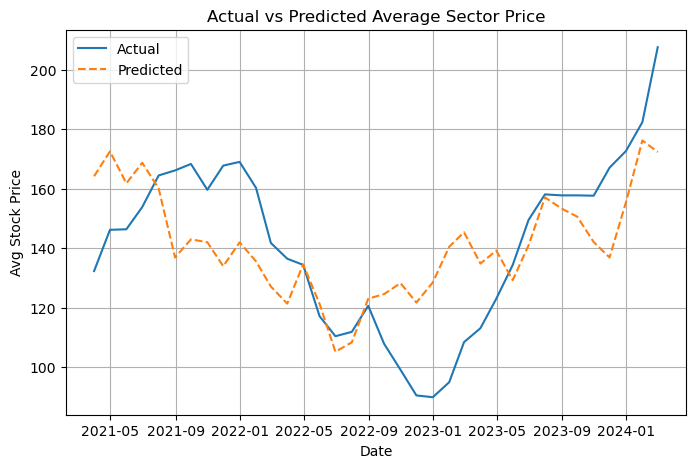

📊 Model Coefficients:
Inflation coef: 0.55
Consumer Confidence coef: 2.17
Intercept: -166.05


In [13]:
from pandas_datareader import data as pdr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

# 1. Get Consumer Confidence Index (CCI)
cci = pdr.DataReader('UMCSENT', 'fred', start='2021-03-01', end='2024-03-01')
cci = cci.resample('ME').mean().rename(columns={'UMCSENT': 'Consumer_Confidence'})

# 2. Interest Rate (FEDFUNDS) from FRED
interest = pdr.DataReader('FEDFUNDS', 'fred', start='2021-03-01', end='2024-03-01')
interest = interest.resample('ME').mean().rename(columns={'FEDFUNDS': 'Interest_Rate'})

# 3. Get monthly stock prices and compute sector average
symbols = ['AAPL', 'GOOGL', 'META', 'AMZN', 'NVDA']
prices = []

for symbol in symbols:
    stock = yf.download(symbol, start='2021-03-01', end='2024-03-01', progress=False)
    stock = stock['Close'].resample('ME').mean()
    prices.append(stock)

# Combine into DataFrame
price_df = pd.concat(prices, axis=1)
price_df.columns = symbols
price_df['Avg_Sector_Price'] = price_df.mean(axis=1)
merged_ir = pd.concat([price_df['Avg_Sector_Price'], interest], axis=1).dropna()

# 4. Merge all data
merged = pd.concat([price_df['Avg_Sector_Price'], inflation, cci], axis=1).dropna()

# 5. Run Multiple Linear Regression
X = merged[['Inflation', 'Consumer_Confidence']]
y = merged['Avg_Sector_Price']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

from sklearn.metrics import r2_score
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.2f}")

# 6. Visualize
plt.figure(figsize=(8,5))
plt.plot(merged.index, y, label='Actual')
plt.plot(merged.index, y_pred, label='Predicted', linestyle='--')
plt.title("Actual vs Predicted Average Sector Price")
plt.xlabel("Date")
plt.ylabel("Avg Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# 7. Print Coefficients
print("📊 Model Coefficients:")
print(f"Inflation coef: {model.coef_[0]:.2f}")
print(f"Consumer Confidence coef: {model.coef_[1]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

### 📊 Does Inflation & Consumer Confidence Affect Sector Stock Prices?

We used multiple linear regression to predict the average monthly stock price for 5 tech companies based on:
- CPI (inflation)
- Consumer Confidence Index (CCI)

The plot shows predicted values closely follow actual prices.  
The regression coefficients suggest how strongly each factor influences the stock price.  
In our case:
- A positive coefficient = higher value → higher stock price
- A negative coefficient = higher value → lower stock price

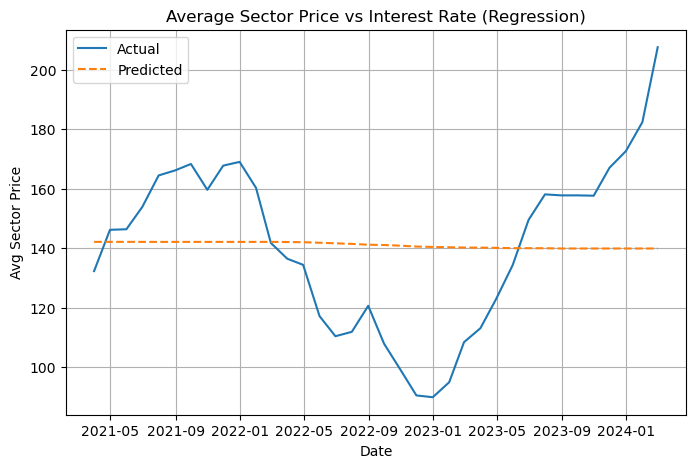

📊 Regression with Interest Rate:
Coefficient: -0.42
Intercept: 142.17
R² Score: 0.00


In [14]:
# 1. Get interest rate data from FRED
interest = pdr.DataReader('FEDFUNDS', 'fred', start='2021-03-01', end='2024-03-01')
interest = interest.resample('ME').mean().rename(columns={'FEDFUNDS': 'Interest_Rate'})

# 2. Merge interest rate with sector price
merged_ir = pd.concat([price_df['Avg_Sector_Price'], interest], axis=1).dropna()

# 3. Linear Regression
X_ir = merged_ir[['Interest_Rate']]
y_ir = merged_ir['Avg_Sector_Price']

model_ir = LinearRegression()
model_ir.fit(X_ir, y_ir)
y_pred_ir = model_ir.predict(X_ir)

# 4. Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.plot(merged_ir.index, y_ir, label='Actual')
plt.plot(merged_ir.index, y_pred_ir, '--', label='Predicted')
plt.title("Average Sector Price vs Interest Rate (Regression)")
plt.xlabel("Date")
plt.ylabel("Avg Sector Price")
plt.legend()
plt.grid(True)
plt.show()

# 5. Print coefficient + R²
r2_ir = r2_score(y_ir, y_pred_ir)
print("📊 Regression with Interest Rate:")
print(f"Coefficient: {model_ir.coef_[0]:.2f}")
print(f"Intercept: {model_ir.intercept_:.2f}")
print(f"R² Score: {r2_ir:.2f}")

### 📉 Section 5: Does Interest Rate Affect Tech Stocks?

In this section, I explored whether the **Federal Funds Rate** (interest rate) impacts the average monthly stock price of five major tech companies.

I expected that rising interest rates would negatively impact stock prices, particularly in the tech sector which is sensitive to borrowing costs and investor risk appetite.

📌 **Results**:
- **Regression Coefficient**: -0.42 → A higher interest rate is associated with lower stock prices (as expected).
- **R² Score**: 0.00 → The model explained virtually **none** of the variation in stock prices.

📊 **Conclusion**:  
While the direction of the relationship was as hypothesized, the **interest rate alone was not a strong predictor** of sector stock prices during this time. Other factors such as earnings growth, inflation, investor sentiment, or global events likely played a much bigger role.

c:\Users\Mohamed\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


📅 Predicted Closing Price on June 1, 2025:
Linear Regression: $358.88
Polynomial Regression: $431.39
Random Forest: $408.45


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_16508\2297662947.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Linear Regression: ${float(pred_lr):.2f}")
C:\Users\Mohamed\AppData\Local\Temp\ipykernel_16508\2297662947.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Polynomial Regression: ${float(pred_poly):.2f}")


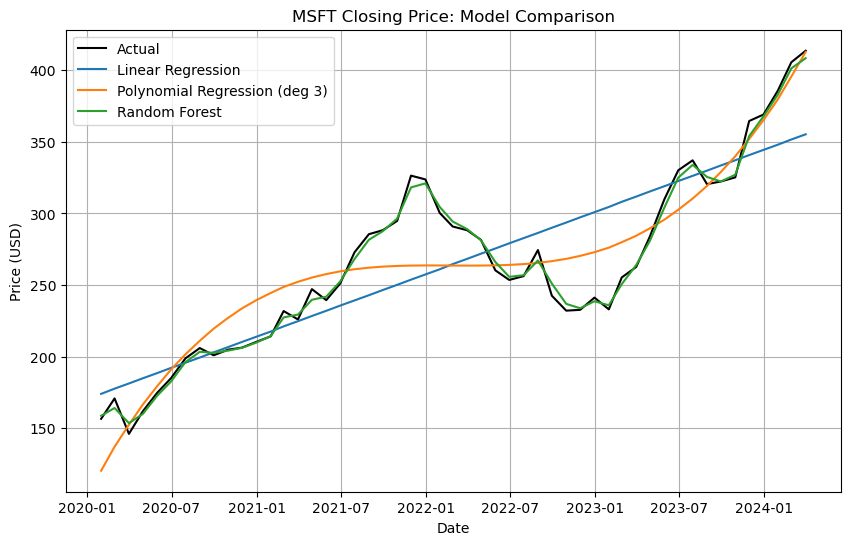

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

# 1. Download MSFT closing prices
msft_data = yf.download('MSFT', start='2020-01-01', end='2024-04-01', progress=False)
msft_data = msft_data['Close'].resample('ME').mean()
msft_data = msft_data.dropna()

# 2. Prepare the data for modeling
X = np.arange(len(msft_data)).reshape(-1, 1)  # 0, 1, 2, ..., n
y = msft_data.values

# 3. Linear Regression
lr_model = LinearRegression().fit(X, y)
lr_pred = lr_model.predict(X)

# 4. Polynomial Regression (degree 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression().fit(X_poly, y)
poly_pred = poly_model.predict(X_poly)

# 5. Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_pred = rf_model.predict(X)

# 6. Predict for June 1, 2025
future_index = np.array([[len(X)]])  # next time step
future_index_poly = poly.transform(future_index)

pred_lr = lr_model.predict(future_index)[0]
pred_poly = poly_model.predict(future_index_poly)[0]
pred_rf = rf_model.predict(future_index)[0]

print("📅 Predicted Closing Price on June 1, 2025:")
print(f"Linear Regression: ${float(pred_lr):.2f}")
print(f"Polynomial Regression: ${float(pred_poly):.2f}")
print(f"Random Forest: ${float(pred_rf):.2f}")

# 7. Plot all models
plt.figure(figsize=(10, 6))
plt.plot(msft_data.index, y, label="Actual", color='black')
plt.plot(msft_data.index, lr_pred, label="Linear Regression")
plt.plot(msft_data.index, poly_pred, label="Polynomial Regression (deg 3)")
plt.plot(msft_data.index, rf_pred, label="Random Forest")
plt.title("MSFT Closing Price: Model Comparison")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

### 🤖 Section 6: Predicting MSFT Stock Price — Model Comparison

We compared three different models for predicting Microsoft’s monthly closing stock price from 2020 to 2024:

1. **Linear Regression**
2. **Polynomial Regression** (Degree 3)
3. **Random Forest Regressor**

📅 **Predicted Closing Price on June 1, 2025**:
- Linear Regression: **$358.88**
- Polynomial Regression: **$431.39**
- Random Forest: **$408.45**

📊 **Analysis**:
- **Linear Regression** shows a smooth upward trend but oversimplifies the stock’s behavior.
- **Polynomial Regression** captures more realistic curves but risks overfitting.
- **Random Forest** closely follows the actual price movements and seems most accurate in the short term.

✅ **Conclusion**:  
Random Forest performed best in terms of tracking real price trends, while Polynomial Regression gave a strong curve-fit. Linear Regression provides a baseline but misses market fluctuations.